# UNIT 6. Regularization and kernel methods

This Unit includes main introduction to regularization and kernel methods, strongly based in {cite:p}`kroese2020`.

```{bibliography}
:style: unsrt
```

In [1]:
""" genham.py """
import numpy as np

def nbe(a,b):  
    numd = len(a) 
    na = a.copy()
    carry= True
    for i in reversed(range(numd)):
        if carry:
            if na[i] == b-1:
                na[i] = 0
            else:
                na[i] = na[i] + 1
                carry = False            
    if carry:
       na.insert(0,1)        
    return(na)

def vdc(b,N):
    out = np.zeros((N,1))
    numd = np.ceil(np.log(N)/np.log(b))
    bb = 1/b**np.arange(1,numd+1)
    a = []
    out[0] = 0
    for i in range(1,N):
        a = nbe(a,b)
        #print(a)
        ar = a[::-1]
        #print(ar, bb[0:len(ar)])
        out[i] = np.sum(ar*bb[0:len(ar)])
    return(out)

def halton(b,N):
   dim = len(b);
   out = np.zeros((N,dim))
   for i in range(0,dim):
      out[:,i] = vdc(b[i],N).reshape((N,))
   return(out)

def hammersley(b,N):
    dim = len(b);
    out = np.zeros((N,dim))
    h = halton(b[0:dim-1],N-1)
    h = h.reshape((N-1,dim-1))
    out[1:N,1:dim] = h
    out[:,0] = np.arange(N)/N
    return(out)

b = [2,3,5]
N = 20
print(hammersley(b,N))

[[0.         0.         0.        ]
 [0.05       0.         0.        ]
 [0.1        0.5        0.33333333]
 [0.15       0.25       0.66666667]
 [0.2        0.75       0.11111111]
 [0.25       0.125      0.44444444]
 [0.3        0.625      0.77777778]
 [0.35       0.375      0.22222222]
 [0.4        0.875      0.55555556]
 [0.45       0.0625     0.88888889]
 [0.5        0.5625     0.03703704]
 [0.55       0.3125     0.37037037]
 [0.6        0.8125     0.7037037 ]
 [0.65       0.1875     0.14814815]
 [0.7        0.6875     0.48148148]
 [0.75       0.4375     0.81481481]
 [0.8        0.9375     0.25925926]
 [0.85       0.03125    0.59259259]
 [0.9        0.53125    0.92592593]
 [0.95       0.28125    0.07407407]]


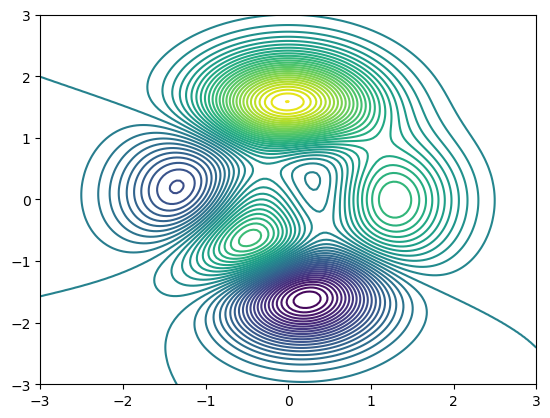

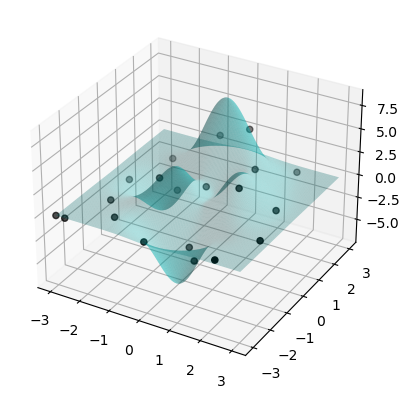

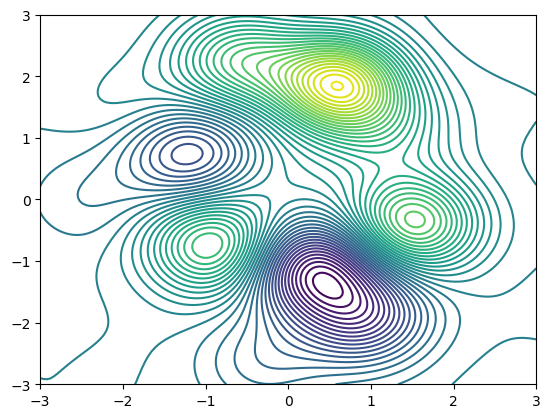

In [ ]:
""" peakskernel.py """
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import norm

import numpy as np
def peaks(x,y):
    z =  (3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) 
          - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2)
          - 1/3 * np.exp(-(x+1)**2 - y**2)) 
    return(z)
 
n = 20
x = -3 + 6*hammersley([2,3],n)
z = peaks(x[:,0],x[:,1])
xx, yy = np.mgrid[-3:3:150j,-3:3:150j]
zz = peaks(xx,yy)
plt.contour(xx,yy,zz,levels=50)

fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,color='c',alpha=0.3,linewidth=0)
ax.scatter(x[:,0],x[:,1],z,color='k',s=20)
plt.show()

sig2 = 0.3 # kernel parameter
def k(x,u):
    return(np.exp(-0.5*norm(x- u)**2/sig2))
K = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        K[i,j] = k(x[i,:],x[j])
alpha = np.linalg.solve(K@K.T, K@z)       



N, = xx.flatten().shape
Kx = np.zeros((n,N))
for i in range(n):
    for j in range(N):
        Kx[i,j] = k(x[i,:],np.array([xx.flatten()[j],yy.flatten()[j]]))

g = Kx.T @ alpha
dim = np.sqrt(N).astype(int)
yhat = g.reshape((dim,dim))
plt.contour(xx,yy,yhat,levels=50)

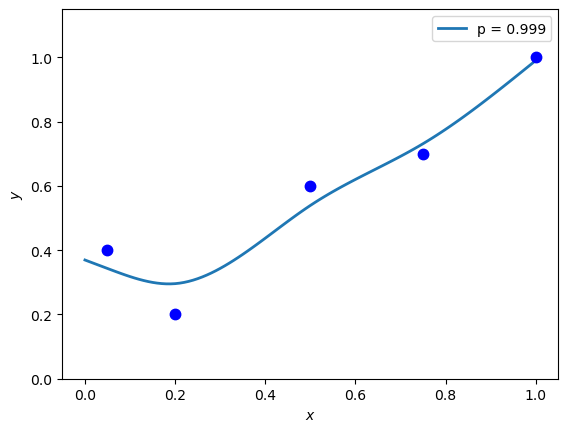

In [2]:
""" smoothspline.py """
# %% 
import matplotlib.pyplot as plt
import numpy as np 

x = np.array([[0.05, 0.2, 0.5, 0.75, 1.]]).T
y = np.array([[0.4, 0.2, 0.6, 0.7, 1.]]).T

n = x.shape[0]
p = 0.999
ngamma = (1-p)/p

k = lambda x1, x2 : (1/2)* np.max((x1,x2)) * np.min((x1,x2)) ** 2 \
                           - ((1/6)* np.min((x1,x2))**3)
K = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        K[i,j] = k(x[i], x[j])

Q = np.hstack((np.ones((n,1)), x))
      
m1 = np.hstack((K @ K.T + (ngamma * K), K @ Q)) 
m2 = np.hstack((Q.T @ K.T, Q.T @ Q))
M = np.vstack((m1,m2))

c = np.vstack((K, Q.T)) @ y

ad = np.linalg.solve(M,c)

# plot the curve
xx = np.arange(0,1+0.01,0.01).reshape(-1,1)

g = np.zeros_like(xx)
Qx = np.hstack((np.ones_like(xx), xx))
g = np.zeros_like(xx)
N = np.shape(xx)[0]

Kx = np.zeros((n,N))
for i in range(n):
    for j in range(N):
        Kx[i,j] = k(x[i], xx[j])
            
g = g + np.hstack((Kx.T, Qx)) @ ad

plt.ylim((0,1.15))
plt.plot(xx, g, label = 'p = {}'.format(p), linewidth = 2)
plt.plot(x,y, 'b.', markersize=15)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

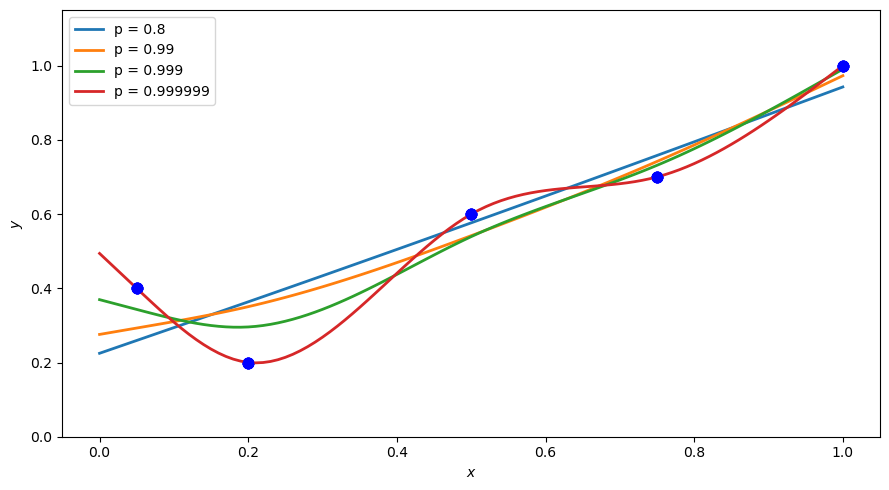

In [3]:
''' smoothspline_fig.py '''
# %% 
import matplotlib.pyplot as plt
import numpy as np 

#from matplotlib import rc
#rc('text', usetex=True)

x = np.array([[0.05, 0.2, 0.5, 0.75, 1.]]).T
y = np.array([[0.4, 0.2, 0.6, 0.7, 1.]]).T

n = x.shape[0]

plt.clf()
p_vals = [0.8, 0.99, 0.999, 0.999999]
plt_params = ['-', '-', '-', '-']

k = lambda x1, x2 : (1/2)* np.max((x1,x2)) * np.min((x1,x2)) ** 2 - \
                            ((1/6)* np.min((x1,x2))**3)

for p, prm in zip(p_vals, plt_params): 
    ngamma = (1-p)/p
    
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j] = k(x[i], x[j])
    
    Q = np.hstack((np.ones((n,1)), x))
          
    m1 = np.hstack((K @ K.T + (ngamma * K), K @ Q)) 
    m2 = np.hstack((Q.T @ K.T, Q.T @ Q))
    M = np.vstack((m1,m2))
    
    c = np.vstack((K, Q.T)) @ y 
    ad = np.linalg.solve(M,c)
    
    # plot the curves
    xx = np.arange(0,1+0.01,0.01).reshape(-1,1)
    
    g = np.zeros_like(xx)
    Qx = np.hstack((np.ones_like(xx), xx))
    g = np.zeros_like(xx)
    N = np.shape(xx)[0]
    
    Kx = np.zeros((n,N))
    for i in range(n):
        for j in range(N):
            Kx[i,j] = k(x[i], xx[j])
                
    g = g + np.hstack((Kx.T, Qx)) @ ad
    plt.plot(xx, g, prm, label = 'p = {}'.format(p), linewidth = 2)
    plt.plot(x,y, 'b.', markersize=15)

plt.ylim((0,1.15))
plt.xlabel('$x$')
plt.ylabel('$y$')   
plt.gcf().set_size_inches(9,5)    
plt.tight_layout()
plt.legend()